In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet
from prophet.plot import plot_plotly

%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [33]:
df = pd.read_csv("store_sales_data_clean_20240214.csv")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9800 non-null   int64  
 1   Order Date    9800 non-null   object 
 2   Segment       9800 non-null   object 
 3   Region        9800 non-null   object 
 4   Category      9800 non-null   object 
 5   Sub-Category  9800 non-null   object 
 6   Sales         9800 non-null   float64
 7   Day of Week   9800 non-null   int64  
 8   Day           9800 non-null   int64  
 9   Year          9800 non-null   int64  
 10  Month         9800 non-null   int64  
 11  Season        9800 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 918.9+ KB


In [35]:
df.head()

,Unnamed: 0,Order Date,Segment,Region,Category,Sub-Category,Sales,Day of Week,Day,Year,Month,Season
0,0,2017-11-08,Consumer,South,Furniture,Bookcases,261.9600,2,8,2017,11,Autumn
1,1,2017-11-08,Consumer,South,Furniture,Chairs,731.9400,2,8,2017,11,Autumn
2,2,2017-06-12,Corporate,West,Office Supplies,Labels,14.6200,0,12,2017,6,Summer
3,3,2016-10-11,Consumer,South,Furniture,Tables,957.5775,1,11,2016,10,Autumn
4,4,2016-10-11,Consumer,South,Office Supplies,Storage,22.3680,1,11,2016,10,Autumn


In [36]:
# Group sales data by day, sort by Order Date
df_grouped = df.groupby('Order Date').agg({'Sales': 'sum'}).reset_index()
df_grouped = df_grouped.sort_values(by='Order Date', ascending=True)
df_grouped['Order Date'] = pd.to_datetime(df_grouped['Order Date'])



In [37]:
is_one_day_apart = (df_grouped['Order Date'].diff().dt.days == 1).all()

# Print the result
print("Dates are each one day apart:", is_one_day_apart)


Dates are each one day apart: False


In [38]:
# Set the 'Order Date' column as the index
df_grouped = df_grouped.set_index('Order Date')

# Create a new DataFrame with a daily frequency
daily_index = pd.date_range(start='2015-01-01', end='2018-12-31', freq='D')
df_daily = pd.DataFrame(index=daily_index)

# Merge the original DataFrame with the new DataFrame, filling missing values with 0
df_merged = df_daily.merge(df_grouped, how='left', left_index=True, right_index=True).fillna(0)

# Reset the index
df_merged = df_merged.reset_index()

# Rename the columns
df_merged = df_merged.rename(columns={'index': 'Order Date'})

# Print the result
print(df_merged)


     Order Date      Sales
0    2015-01-01     0.0000
1    2015-01-02     0.0000
2    2015-01-03    16.4480
3    2015-01-04   288.0600
4    2015-01-05    19.5360
...         ...        ...
1456 2018-12-27   177.6360
1457 2018-12-28  1657.3508
1458 2018-12-29  2915.5340
1459 2018-12-30   713.7900
1460 2018-12-31     0.0000

[1461 rows x 2 columns]


In [39]:
# Split data into train and test 
df_train = df_merged[:-31]
df_test = df_merged[-31:]

## Model 1 - Simple Moving Average

In [40]:
# Calculate the SMA/rolling average with different timeframes 
df_train['SMA 10'] = df_train['Sales'].rolling(window=10).mean()
df_train['SMA 30'] = df_train['Sales'].rolling(window=30).mean()
df_train['SMA 90'] = df_train['Sales'].rolling(window=90).mean()
df_train['SMA 180'] = df_train['Sales'].rolling(window=180).mean()
df_train['SMA 365'] = df_train['Sales'].rolling(window=365).mean()
df_train['Order Date'] = pd.to_datetime(df_train['Order Date']) 


C:\Users\zive9\AppData\Local\Temp\ipykernel_18960\4024228539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['SMA 10'] = df_train['Sales'].rolling(window=10).mean()
C:\Users\zive9\AppData\Local\Temp\ipykernel_18960\4024228539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['SMA 30'] = df_train['Sales'].rolling(window=30).mean()
C:\Users\zive9\AppData\Local\Temp\ipykernel_18960\4024228539.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

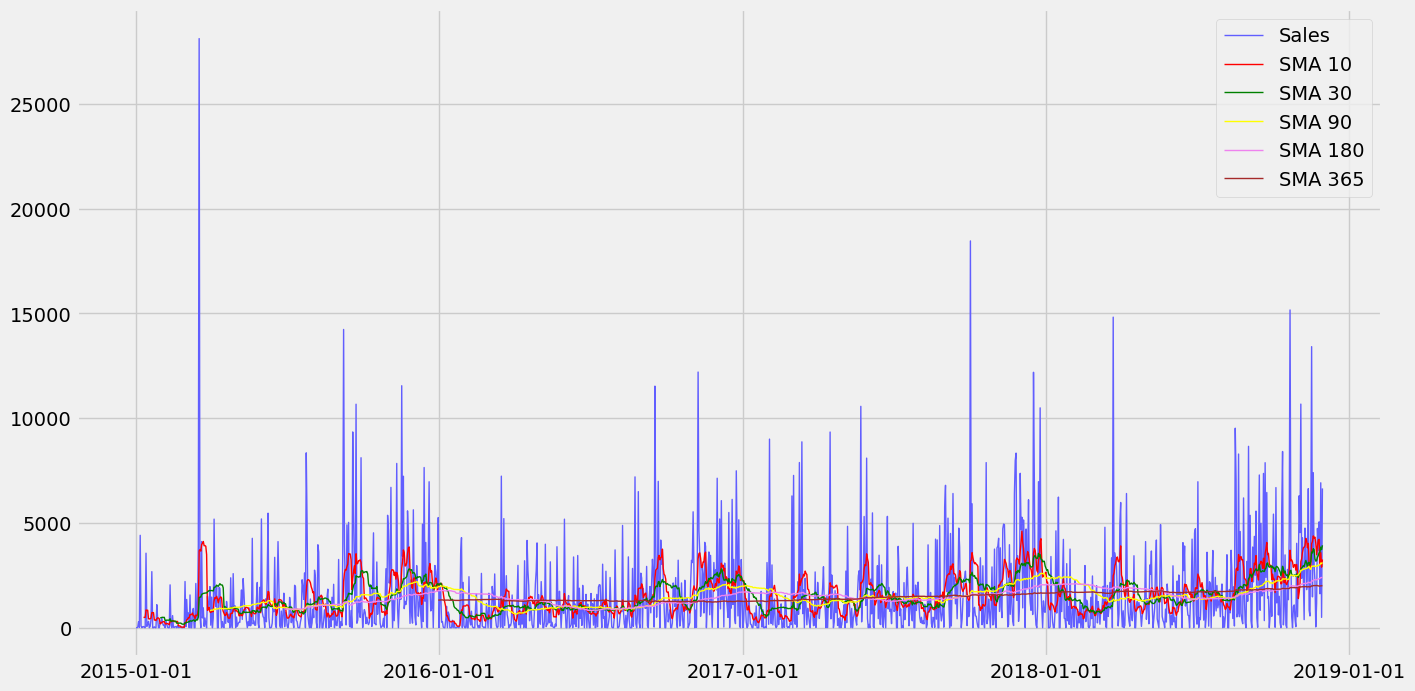

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [41]:
plt.figure(figsize=(15, 8))

plt.plot(df_train['Order Date'], df_train['Sales'], color='#615eff', label='Sales', linewidth=1)
plt.plot(df_train['Order Date'], df_train['SMA 10'], color='red', label='SMA 10', linewidth=1)
plt.plot(df_train['Order Date'], df_train['SMA 30'], color='green', label='SMA 30', linewidth=1)
plt.plot(df_train['Order Date'], df_train['SMA 90'], color='yellow', label='SMA 90', linewidth=1)
plt.plot(df_train['Order Date'], df_train['SMA 180'], color='violet', label='SMA 180', linewidth=1)
plt.plot(df_train['Order Date'], df_train['SMA 365'], color='brown', label='SMA 365', linewidth=1)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-01-01'))

plt.legend()
plt.show()
plt.figure(figsize=(15, 8))



### Forecast sales

In [42]:
# Forecasts for the period 2019-01-01 to 2019-01-31

print("10 Day SMA Forecast: ", sum(df_train['SMA 10'].iloc[-31:]))
print("30 Day SMA Forecast: ", sum(df_train['SMA 30'].iloc[-31:]))
print("90 Day SMA Forecast: ", sum(df_train['SMA 90'].iloc[-31:]))
print("180 Day SMA Forecast: ", sum(df_train['SMA 180'].iloc[-31:]))
print("365 Day SMA Forecast: ", sum(df_train['SMA 365'].iloc[-31:]))

10 Day SMA Forecast:  108075.89670000001
30 Day SMA Forecast:  98986.71281333333
90 Day SMA Forecast:  88492.80845555557
180 Day SMA Forecast:  67896.92129833336
365 Day SMA Forecast:  61080.50391561645


In [43]:
# RMSE 
print("10 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_train['SMA 10'].iloc[-31:])))
print("30 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_train['SMA 30'].iloc[-31:])))
print("90 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_train['SMA 90'].iloc[-31:])))
print("180 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_train['SMA 180'].iloc[-31:])))
print("365 Day SMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], df_train['SMA 365'].iloc[-31:])))

10 Day SMA Error:  2848.559450825329
30 Day SMA Error:  2717.508248004228
90 Day SMA Error:  2552.9630369101624
180 Day SMA Error:  2572.685185828768
365 Day SMA Error:  2592.420582024853


Best window for SMA forecast is 90 days. 

In [44]:
# MAE
print("10 Day SMA Error: ", mean_absolute_error(df_test['Sales'], df_train['SMA 10'].iloc[-31:]))
print("30 Day SMA Error: ", mean_absolute_error(df_test['Sales'], df_train['SMA 30'].iloc[-31:]))
print("90 Day SMA Error: ", mean_absolute_error(df_test['Sales'], df_train['SMA 90'].iloc[-31:]))
print("180 Day SMA Error: ", mean_absolute_error(df_test['Sales'], df_train['SMA 180'].iloc[-31:]))
print("365 Day SMA Error: ", mean_absolute_error(df_test['Sales'], df_train['SMA 365'].iloc[-31:]))


10 Day SMA Error:  2302.858959354839
30 Day SMA Error:  2221.947708387097
90 Day SMA Error:  2016.8584516845883
180 Day SMA Error:  1872.931910591398
365 Day SMA Error:  1832.4494867697745


## Model 2 - ARIMA

In [45]:
# Format the data
df_arima_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_arima_train = df_arima_train.asfreq('D')

# Grid search to find the best parameters for ARIMA model
p = range(0, 3)  # Example: considering 0, 1, 2
d = range(0, 3)  # Example: considering 0, 1, 2
q = range(0, 3)  # Example: considering 0, 1, 2

pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(df_arima_train, order=param)
        results = model.fit()

        # Compare this model's AIC to the best (lowest) AIC found so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:  # Catch and ignore exceptions caused by unfit model specifications
        continue

print(f"Best ARIMA{best_pdq}\n\n Best AIC: {best_aic}")


c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zi

Best ARIMA(0, 2, 2)

 Best AIC: 25975.21382207881


c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecast

In [47]:
arima = ARIMA(df_arima_train, order=best_pdq)
arima_fit = arima.fit()

forecast_arima = arima_fit.forecast(steps=31)
forecast_arima

2018-12-01    3540.123938
2018-12-02    3542.302705
2018-12-03    3544.481471
2018-12-04    3546.660237
2018-12-05    3548.839003
2018-12-06    3551.017770
2018-12-07    3553.196536
2018-12-08    3555.375302
2018-12-09    3557.554068
2018-12-10    3559.732835
2018-12-11    3561.911601
2018-12-12    3564.090367
2018-12-13    3566.269133
2018-12-14    3568.447900
2018-12-15    3570.626666
2018-12-16    3572.805432
2018-12-17    3574.984198
2018-12-18    3577.162965
2018-12-19    3579.341731
2018-12-20    3581.520497
2018-12-21    3583.699263
2018-12-22    3585.878030
2018-12-23    3588.056796
2018-12-24    3590.235562
2018-12-25    3592.414328
2018-12-26    3594.593095
2018-12-27    3596.771861
2018-12-28    3598.950627
2018-12-29    3601.129393
2018-12-30    3603.308160
2018-12-31    3605.486926
Freq: D, Name: predicted_mean, dtype: float64

In [48]:
# RMSE
error_arima = np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima))
print("ARIMA Error: ", np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima)))

ARIMA Error:  2649.324384216075


## SARIMA Daily

# Trying SARIMA with the daily data 

# Format the data
# df_sm_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
# df_sm_train = df_sm_train.resample('M').sum()
# df_sm_test = df_test[['Order Date', 'Sales']].set_index('Order Date')
# df_sm_test = df_sm_test.resample('M').sum()

df_sm_daily_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_sm_daily_test = df_test[['Order Date', 'Sales']].set_index('Order Date')

# Grid search to find the best parameters for SARIMA model
# p = range(0, 2)  # Example: considering 0, 1, 2
# d = range(0, 2)  # Example: considering 0, 1, 2
# q = range(0, 2)  # Example: considering 0, 1, 2

# P = range(0, 2)
# D = range(0, 2)
# Q = range(0, 2)
# S = [365]

# param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

# best_aic = np.inf
# best_params = None

# for params in param_combinations:
#     try:
#         sm = SARIMAX(df_sm_daily_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
#         results = sm.fit(disp=False)
        
#         if results.aic < best_aic:
#             best_aic = results.aic
#             best_params = params
#     except:
#         continue

# print(f"Best AIC: {best_aic}")
# print(f"Best Parameters: {best_params}")

### Forecast

# SARIMA daily grid search is very slow, so taking params from ARIMA
inf_params = (2, 2, 2, 2, 2, 2, 365)

sm_daily = SARIMAX(df_sm_daily_train, order=inf_params[:3], seasonal_order=inf_params[3:], enforce_stationarity=False, enforce_invertibility=False)
sm_daily_fit = sm_daily.fit()

forecast_sarima_daily = sm_daily_fit.forecast(steps=30)
forecast_sarima_daily

# RMSE
error_sarima_daily = np.sqrt(mean_squared_error(df_sm_daily_test['Sales'], forecast_sarima_daily))
print("SARIMA Daily Error: ", np.sqrt(mean_squared_error(df_sm_daily_test['Sales'], forecast_sarima_daily)))

## Model 3 - SARIMA, monthly

In [49]:
# Because SARIMAX is slow to compute, we will group by month instead of day

# Format the data
df_sm_train = df_train[['Order Date', 'Sales']].set_index('Order Date')
df_sm_train = df_sm_train.resample('M').sum()
df_sm_test = df_test[['Order Date', 'Sales']].set_index('Order Date')
df_sm_test = df_sm_test.resample('M').sum()

# Grid search to find the best parameters for SARIMA model
p = range(0, 3)  # Example: considering 0, 1, 2
d = range(0, 3)  # Example: considering 0, 1, 2
q = range(0, 3)  # Example: considering 0, 1, 2

P = range(0, 3)
D = range(0, 3)
Q = range(0, 3)
S = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, S))

best_aic = np.inf
best_params = None

for params in param_combinations:
    try:
        sm = SARIMAX(df_sm_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
        results = sm.fit(disp=False)
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

print(f"Best AIC: {best_aic}")
print(f"Best Parameters: {best_params}")




c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters

Best AIC: 6.0
Best Parameters: (0, 0, 0, 0, 2, 2, 12)


### Forecast

In [50]:
sm = SARIMAX(df_sm_train, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
sm_fit = sm.fit()

forecast_sarima = sm_fit.forecast(steps=1)
forecast_sarima

c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2018-12-31    144536.978429
Freq: M, dtype: float64

In [51]:
# RMSE
error_sarima = np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima))
print("SARIMAX Error: ", np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima)))

SARIMAX Error:  61506.58962938179


## Model 4 - Prophet model

In [52]:
#Format the training and test data for Prophet
df_pt_train = df_train[['Order Date', 'Sales']]
df_pt_train = df_pt_train.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

df_pt_test = df_test[['Order Date', 'Sales']]
df_pt_test = df_pt_test.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

In [53]:
# Instantiate the Prophet model
pt = Prophet()

pt_fit = pt.fit(df_pt_train)

14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing


### Forecast

In [54]:
future = pt_fit.make_future_dataframe(periods=31)

forecast_pt = pt_fit.predict(future)
forecast_pt

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,1234.272705,-2089.349047,3048.895431,1234.272705,1234.272705,-842.354290,-842.354290,-842.354290,-835.238960,-835.238960,-835.238960,-7.115330,-7.115330,-7.115330,0.0,0.0,0.0,391.918415
1,2015-01-02,1234.433472,-1803.733485,3243.971789,1234.433472,1234.433472,-557.797315,-557.797315,-557.797315,-434.417252,-434.417252,-434.417252,-123.380062,-123.380062,-123.380062,0.0,0.0,0.0,676.636157
2,2015-01-03,1234.594238,-1184.245660,4083.645960,1234.594238,1234.594238,190.491068,190.491068,190.491068,426.984199,426.984199,426.984199,-236.493131,-236.493131,-236.493131,0.0,0.0,0.0,1425.085306
3,2015-01-04,1234.755005,-1489.187818,3765.874523,1234.755005,1234.755005,-107.109306,-107.109306,-107.109306,237.809254,237.809254,237.809254,-344.918560,-344.918560,-344.918560,0.0,0.0,0.0,1127.645699
4,2015-01-05,1234.915771,-1510.751917,3538.837767,1234.915771,1234.915771,-326.974547,-326.974547,-326.974547,120.230901,120.230901,120.230901,-447.205448,-447.205448,-447.205448,0.0,0.0,0.0,907.941224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,2255.821717,-703.424309,4665.097326,2255.447523,2256.068294,-269.085416,-269.085416,-269.085416,-835.238960,-835.238960,-835.238960,566.153544,566.153544,566.153544,0.0,0.0,0.0,1986.736301
1457,2018-12-28,2257.124203,-158.802811,4851.029115,2256.721627,2257.400289,23.293135,23.293135,23.293135,-434.417252,-434.417252,-434.417252,457.710387,457.710387,457.710387,0.0,0.0,0.0,2280.417337
1458,2018-12-29,2258.426688,331.768334,5695.523227,2257.988823,2258.764387,771.666015,771.666015,771.666015,426.984199,426.984199,426.984199,344.681816,344.681816,344.681816,0.0,0.0,0.0,3030.092703
1459,2018-12-30,2259.729174,101.298095,5308.287357,2259.253115,2260.103484,466.316707,466.316707,466.316707,237.809254,237.809254,237.809254,228.507452,228.507452,228.507452,0.0,0.0,0.0,2726.045881


In [55]:
# RMSE
rmse_pt = np.sqrt(mean_squared_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-31:]))
print("Prophet Error: ", rmse_pt)

Prophet Error:  2359.9622186223105


In [56]:
future_60 = pt_fit.make_future_dataframe(periods=62)

forecast_pt_60 = pt_fit.predict(future_60)
forecast_jan = forecast_pt_60[-31:]
forecast_jan['yhat'].sum()

50492.66526263412

## Model 5 - VAR

In [57]:
# We need to check if the categorical variables can be one hot encoded 
print(df['Category'].value_counts())
print("\n", df['Sub-Category'].value_counts())
print("\n", df['Region'].value_counts())
print("\n", df['Segment'].value_counts())

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64

 Sub-Category
Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: count, dtype: int64

 Region
West       3140
East       2785
Central    2277
South      1598
Name: count, dtype: int64

 Segment
Consumer       5101
Corporate      2953
Home Office    1746
Name: count, dtype: int64


In [58]:
# Select categorical variables and get dummies 
df_var = df[['Order Date', 'Sales', 'Category', 'Region', 'Segment']]
df_var.set_index('Order Date', inplace=True)
df_var_dum = pd.get_dummies(df_var, columns=['Category', 'Region', 'Segment'], drop_first=True, dtype=int)

In [59]:
df_var_dum.head()

,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
Order Date,,,,,,,,
2017-11-08,261.9600,0,0,0,1,0,0,0
2017-11-08,731.9400,0,0,0,1,0,0,0
2017-06-12,14.6200,1,0,0,0,1,1,0
2016-10-11,957.5775,0,0,0,1,0,0,0
2016-10-11,22.3680,1,0,0,1,0,0,0


In [60]:
df_var_grp = df_var_dum.groupby('Order Date').agg({'Sales': 'sum', 'Category_Office Supplies': 'sum', 'Category_Technology': 'sum', 'Region_East': 'sum', 'Region_South': 'sum', 'Region_West': 'sum', 'Segment_Corporate': 'sum', 'Segment_Home Office': 'sum'}).reset_index()

In [61]:
df_var_grp

,Order Date,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
0,2015-01-03,16.4480,1,0,0,0,0,0,0
1,2015-01-04,288.0600,3,0,0,0,0,0,3
2,2015-01-05,19.5360,1,0,1,0,0,0,0
3,2015-01-06,4407.1000,6,2,0,8,1,1,7
4,2015-01-07,87.1580,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1225,2018-12-26,814.5940,4,0,1,0,0,2,1
1226,2018-12-27,177.6360,1,1,2,0,0,2,0
1227,2018-12-28,1657.3508,12,1,4,1,6,8,3
1228,2018-12-29,2915.5340,5,1,1,5,5,2,0


In [62]:
# Change Order Date to datetime
df_var_grp['Order Date'] = pd.to_datetime(df_var_grp['Order Date'])

# Check for missing days
is_one_day_apart = (df_var_grp['Order Date'].diff().dt.days == 1).all()
print("Dates are each one day apart:", is_one_day_apart)


Dates are each one day apart: False


In [63]:
# Add the missing days with 0 values for all variables 
daily_index = pd.date_range(start='2015-01-01', end='2018-12-31', freq='D')
df_var_daily = pd.DataFrame(index=daily_index)

# Now we merge the original DataFrame with the new DataFrame, filling missing values with 0
df_var_merged = df_var_daily.merge(df_var_grp, how='left', left_index=True, right_on='Order Date').fillna(0)


In [64]:
# Order the dataframes by 'Order Date'
df_var_merged = df_var_merged.sort_values(by='Order Date', ascending=True)

# Set the 'Order Date' column as the index
df_var_merged = df_var_merged.set_index('Order Date')

In [65]:
df_var_merged

,Sales,Category_Office Supplies,Category_Technology,Region_East,Region_South,Region_West,Segment_Corporate,Segment_Home Office
Order Date,,,,,,,,
2015-01-01,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,16.4480,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,288.0600,3.0,0.0,0.0,0.0,0.0,0.0,3.0
2015-01-05,19.5360,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-12-27,177.6360,1.0,1.0,2.0,0.0,0.0,2.0,0.0
2018-12-28,1657.3508,12.0,1.0,4.0,1.0,6.0,8.0,3.0
2018-12-29,2915.5340,5.0,1.0,1.0,5.0,5.0,2.0,0.0


In [66]:
# Run ADF test for each variable to check for stationarity
for column in df_var_merged.columns:
    result = adfuller(df_var_merged[column])
    print(f"ADF Statistic for {column}: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print("\n")

ADF Statistic for Sales: -4.942060643777008
p-value: 2.8863182713335816e-05
Critical Values: {'1%': -3.434899302257815, '5%': -2.8635492080466607, '10%': -2.567839687982253}


ADF Statistic for Category_Office Supplies: -4.53121302550875
p-value: 0.00017262125084250773
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}


ADF Statistic for Category_Technology: -4.7832713301234016
p-value: 5.853832834828708e-05
Critical Values: {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}


ADF Statistic for Region_East: -5.0754900945056365
p-value: 1.5700269919873997e-05
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}


ADF Statistic for Region_South: -6.99685727811808
p-value: 7.49495323367428e-10
Critical Values: {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}


ADF Statistic for Region_West: -4.846944669834136
p-value: 4.4188601197954705

In [67]:
# Split data into train and test 
df_var_train = df_var_merged[:-31]
df_var_test = df_var_merged[-31:]

### Fitting the model

In [68]:
# Instantiate and fit the model
vm = VAR(df_var_train)
vm_results = vm.fit(maxlags=15, ic='aic')

print(vm_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Mar, 2024
Time:                     14:17:55
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    23.8717
Nobs:                     1429.00    HQIC:                   23.7055
Log likelihood:          -33016.1    FPE:                1.78713e+10
AIC:                      23.6065    Det(Omega_mle):     1.69958e+10
--------------------------------------------------------------------
Results for equation Sales
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                            1042.051286        82.420997           12.643           0.000
L1.Sales                           -0.006249         0.034651           -0.180           0.857
L1.C

c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Forecast

In [69]:
lag_order = vm_results.k_ar
forecasted_values = vm_results.forecast(df_var_merged.values[-lag_order:], steps=31)
forecasted_values

array([[1.04205129e+03, 2.87553980e+00, 8.39320269e-01, 1.35508722e+00,
        7.77923175e-01, 1.53396216e+00, 1.47774668e+00, 8.77433113e-01],
       [1.39032528e+03, 3.64800134e+00, 1.11172482e+00, 1.71759977e+00,
        9.88891442e-01, 1.93653202e+00, 1.83420884e+00, 1.09854239e+00],
       [1.48782716e+03, 3.86029810e+00, 1.18768095e+00, 1.81984280e+00,
        1.04814569e+00, 2.04507589e+00, 1.93498507e+00, 1.15794827e+00],
       [1.51487064e+03, 3.91932932e+00, 1.20872057e+00, 1.84824379e+00,
        1.06465473e+00, 2.07529796e+00, 1.96290329e+00, 1.17447677e+00],
       [1.52237874e+03, 3.93571092e+00, 1.21456162e+00, 1.85612772e+00,
        1.06923348e+00, 2.08368905e+00, 1.97065380e+00, 1.17906971e+00],
       [1.52446215e+03, 3.94025724e+00, 1.21618265e+00, 1.85831612e+00,
        1.07050402e+00, 2.08601778e+00, 1.97280544e+00, 1.18034390e+00],
       [1.52504037e+03, 3.94151909e+00, 1.21663255e+00, 1.85892347e+00,
        1.07085665e+00, 2.08666414e+00, 1.97340259e+00, 1.

In [70]:
# Convert forecasted_values to DataFrame for easy manipulation
forecasted_df = pd.DataFrame(forecasted_values, index=df_var_test.index, columns=df_var_test.columns)

# RMSE
rmse_var = np.sqrt(mean_squared_error(df_var_test['Sales'], forecasted_df['Sales']))
rmse_var

2778.2028568114847

C:\Users\zive9\AppData\Local\Temp\ipykernel_18960\2618675798.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=df_errors, palette='plasma')


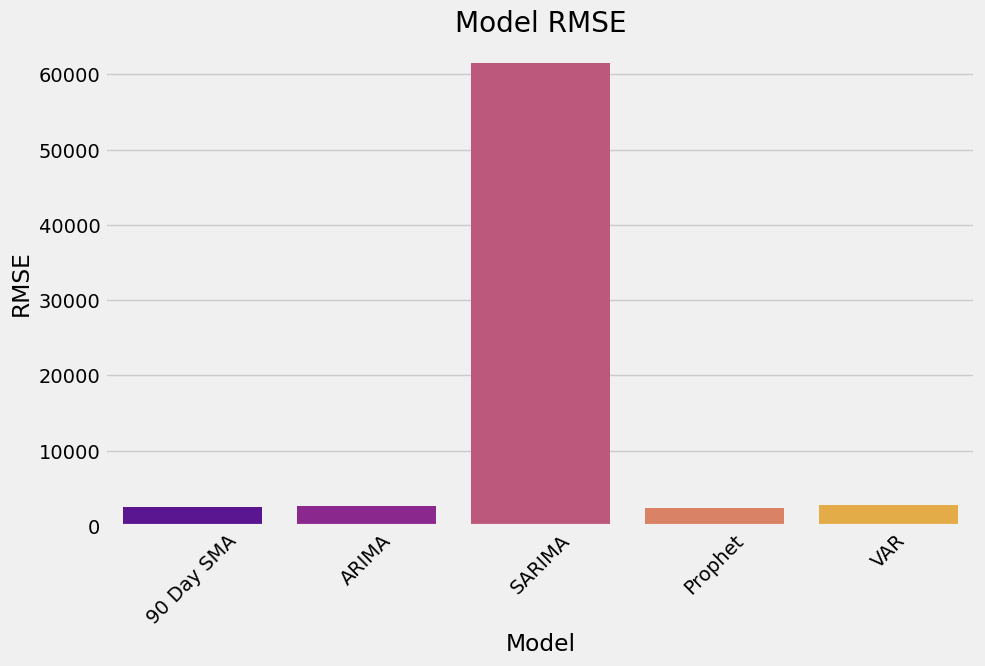

In [75]:
# Put all the errors into one dataframe 
df_errors = pd.DataFrame({
    'Model': ['90 Day SMA', 'ARIMA', 'SARIMA', 'Prophet', 'VAR'],
    'RMSE': [np.sqrt(mean_squared_error(df_test['Sales'], df_train['SMA 90'].iloc[-31:])), 
             np.sqrt(mean_squared_error(df_test['Sales'], forecast_arima)), 
            np.sqrt(mean_squared_error(df_sm_test['Sales'], forecast_sarima)),
             np.sqrt(mean_squared_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-31:])), 
             np.sqrt(mean_squared_error(df_var_test['Sales'], forecasted_df['Sales']))]
})

# Plot a bar chart of the errors
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=df_errors, palette='plasma')
plt.title('Model RMSE')
plt.xticks(rotation=45)
plt.show()

In [78]:
# Calculate mean absolute errors in a dataframe
df_errors['MAE'] = (mean_absolute_error(df_test['Sales'], df_train['SMA 90'].iloc[-31:]), 
             mean_absolute_error(df_test['Sales'], forecast_arima), 
            mean_absolute_error(df_sm_test['Sales'], forecast_sarima),
             mean_absolute_error(df_pt_test['y'], forecast_pt['yhat'].iloc[-31:]), 
             mean_absolute_error(df_var_test['Sales'], forecasted_df['Sales'])
)

In [79]:
df_errors

,Model,RMSE,MAE
0,90 Day SMA,2552.963037,2016.858452
1,ARIMA,2649.324384,2275.775903
2,SARIMA,61506.589629,61506.589629
3,Prophet,2359.962219,1954.670438
4,VAR,2778.202857,1920.819310
